# Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [14]:
from time import sleep

In [3]:
PATH = 'data/planet/'

## Multi-label versus single-label classification

In [3]:
from fastai.plots import *

In [9]:
def get_1st(path): return glob(f'{path}/*.*')[0]

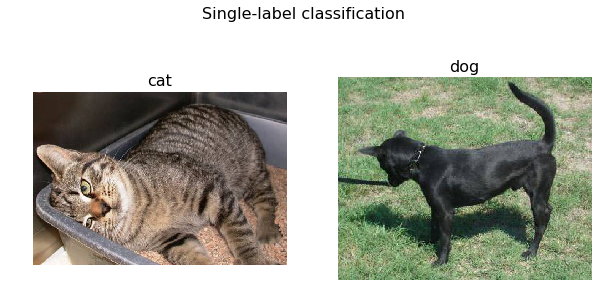

In [23]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

In [15]:
os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

In [18]:
!ls /datasets/kaggle/planet-understanding-the-amazon-from-space/

__MACOSX		  test-jpg-additional	    train-jpg
sample_submission_v2.csv  test-tif-v2		    train-tif-v2
test-jpg		  test_v2_file_mapping.csv  train_v2.csv


In [20]:
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

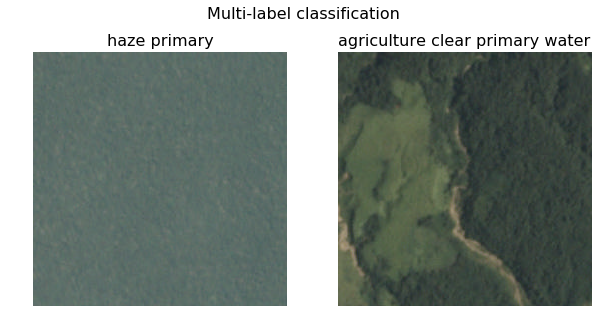

In [24]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [4]:
from planet import f2

sz=256
metrics=[f2]
f_model = resnet34

In [5]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [6]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [7]:
sz=64

In [8]:
data = get_data(sz)

In [10]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [11]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.22286  0.38813  0.82542]                        



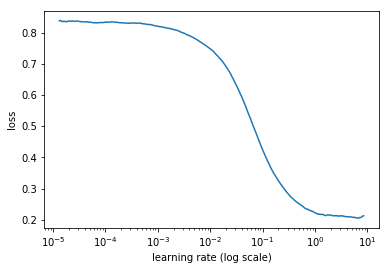

In [12]:
lrf=learn.lr_find()
learn.sched.plot()

In [13]:
lr = 0.2

In [15]:
sleep(2)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.1491   0.13055  0.88448]                        
[ 1.       0.14033  0.12603  0.88995]                        
[ 2.       0.13847  0.12381  0.8918 ]                        
[ 3.       0.1387   0.12593  0.8899 ]                        
[ 4.       0.13502  0.12208  0.89424]                        
[ 5.       0.13181  0.11994  0.89636]                        
[ 6.       0.12992  0.12179  0.89426]                        



In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [19]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.11755  0.10616  0.91124]                        
[ 1.       0.11424  0.10573  0.91011]                        
[ 2.       0.10512  0.09857  0.91676]                        
[ 3.       0.10924  0.10169  0.91549]                        
[ 4.       0.10359  0.0969   0.9197 ]                         
[ 5.       0.09963  0.09506  0.92014]                         
[ 6.       0.1011   0.09559  0.91934]                         



In [20]:
learn.save(f'{sz}')

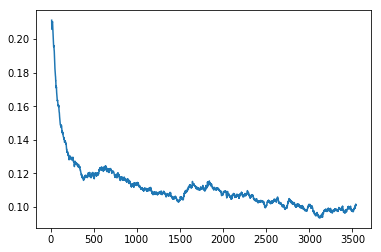

In [22]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

100%|██████████| 127/127 [02:21<00:00,  1.11s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09887  0.09369  0.92056]                         
[ 1.       0.09883  0.09255  0.92101]                         
[ 2.       0.09721  0.09285  0.92062]                         
[ 3.       0.09875  0.09177  0.92199]                         
[ 4.       0.09318  0.09193  0.92147]                         
[ 5.       0.09519  0.09143  0.92185]                         
[ 6.       0.09813  0.09096  0.92196]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09235  0.08738  0.92656]                         
[ 1.       0.09314  0.08696  0.92702]                         
[ 2.       0.0893   0.08463  0.92911]                         
[ 3.       0.08958  0.08635  0.92831]                         
[ 4.       0.08881  0.08606  0.92653]                         
[ 5.       0.08595  0.08519  0.9276 ]                         
[ 6.       0.08593  0.08389  0.92941]                         



In [26]:
sz=256

In [27]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

100%|██████████| 127/127 [03:12<00:00,  1.52s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09125  0.08753  0.92524]                         
[ 1.       0.09321  0.08732  0.92541]                         
[ 2.       0.09034  0.08598  0.92718]                         
[ 3.       0.09165  0.08528  0.92895]                         
[ 4.       0.08902  0.08603  0.92643]                         
[ 5.       0.08921  0.08514  0.92761]                         
[ 6.       0.0888   0.08449  0.92883]                         



In [28]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.08796  0.08089  0.93304]                         
[ 1.       0.08799  0.08209  0.93027]                         
[ 2.       0.08387  0.08026  0.93332]                         
[ 3.       0.08811  0.08196  0.93278]                         
[ 4.       0.08556  0.08158  0.9321 ]                         
[ 5.       0.08096  0.07988  0.93448]                         
[ 6.       0.07744  0.0794   0.9345 ]                         



In [29]:
tta = learn.TTA()

In [30]:
f2(*tta)

0.93529638314119379

### End